Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [1]:
%pip show sambo
import sambo

Name: sambo
Version: 1.25.0
Summary: Sequential And Model-Based Optimization
Home-page: https://sambo-optimization.github.io
Author: 
Author-email: 
License: AGPL-3.0
Location: c:\users\x7498\anaconda3\envs\backtesting\lib\site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
# 1. 导入必要的库
import pandas as pd
import os
from datetime import datetime
from glob import glob

def load_and_resample_data(symbol, start_date, end_date, source_timeframe='1m', target_timeframe='30m', data_path=r'\\znas\Main\futures'):
    """
    加载并重采样期货数据
    
    参数:
        symbol (str): 交易对名称，如 'KASUSDT'
        start_date (str): 开始日期，格式 'YYYY-MM-DD'
        end_date (str): 结束日期，格式 'YYYY-MM-DD'
        source_timeframe (str): 源数据时间周期，默认 '1m'
        target_timeframe (str): 目标时间周期，默认 '30m'
        data_path (str): 数据文件路径
        
    返回:
        pd.DataFrame: 符合backtesting.py格式的DataFrame
    """
    # 生成日期范围
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 准备存储所有数据的列表
    all_data = []
    
    # 标准化交易对名称
    formatted_symbol = symbol.replace('/', '_').replace(':', '_')
    if not formatted_symbol.endswith('USDT'):
        formatted_symbol = f"{formatted_symbol}USDT"
    
    # 遍历每一天
    for date in date_range:
        date_str = date.strftime('%Y-%m-%d')
        # 构建文件路径
        file_path = os.path.join(data_path, date_str, f"{date_str}_{formatted_symbol}_USDT_{source_timeframe}.csv")
        
        try:
            if os.path.exists(file_path):
                # 读取数据
                df = pd.read_csv(file_path)
                df['datetime'] = pd.to_datetime(df['datetime'])
                all_data.append(df)
            else:
                print(f"文件不存在: {file_path}")
        except Exception as e:
            print(f"读取文件出错 {file_path}: {str(e)}")
            continue
    
    if not all_data:
        raise ValueError(f"未找到 {symbol} 在指定日期范围内的数据")
    
    # 合并所有数据
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.sort_values('datetime')
    
    # 设置时间索引
    combined_df.set_index('datetime', inplace=True)
    
    # 重采样到目标时间周期
    resampled = combined_df.resample(target_timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()  # 立即删除NaN值
    
    # 转换为backtesting.py格式
    backtesting_df = pd.DataFrame({
        'Open': resampled['open'],
        'High': resampled['high'],
        'Low': resampled['low'],
        'Close': resampled['close'],
        'Volume': resampled['volume']
    })
    
    # 确保所有数据都是数值类型并删除任何无效值
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        backtesting_df[col] = pd.to_numeric(backtesting_df[col], errors='coerce')
    
    # 最终清理
    backtesting_df = backtesting_df.dropna()
    
    return backtesting_df



Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [7]:
# 加载数据
symbol = 'KASUSDT'
start_date = '2024-01-01'
end_date = '2025-01-01'

try:
    backtesting_df = load_and_resample_data(
        symbol=symbol,
        start_date=start_date,
        end_date=end_date,
        source_timeframe='1m',
        target_timeframe='30min'
    )
    
    print(f"数据加载成功:")
    print(f"时间范围: {backtesting_df.index.min()} 到 {backtesting_df.index.max()}")
    print(f"数据条数: {len(backtesting_df)}")
    print("\n数据示例:")
    print(backtesting_df.head())
    
except Exception as e:
    print(f"处理数据时出错: {str(e)}")

数据加载成功:
时间范围: 2024-01-01 00:00:00 到 2025-01-01 23:30:00
数据条数: 17616

数据示例:
                        Open     High      Low    Close     Volume
datetime                                                          
2024-01-01 00:00:00  0.11220  0.11296  0.11204  0.11287  3421830.0
2024-01-01 00:30:00  0.11284  0.11334  0.11172  0.11323  2515295.0
2024-01-01 01:00:00  0.11318  0.11340  0.11288  0.11326  1227419.0
2024-01-01 01:30:00  0.11326  0.11414  0.11326  0.11394  1893081.0
2024-01-01 02:00:00  0.11396  0.11426  0.11328  0.11402  1711190.0


In [8]:
from ConnorsReversalShortStrategy import ConnorsReversalShort


It's not a robust strategy, but we can optimize it.

[Grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)
is an exhaustive search through a set of specified sets of values of hyperparameters. One evaluates the performance for each set of parameters and finally selects the combination that performs best.

Let's optimize our strategy on Google stock data using _randomized_ grid search over the parameter space, evaluating at most (approximately) 200 randomly chosen combinations:

In [5]:
# 使用自定义评分函数(推荐)
def custom_score(stats):
    """
    自定义评分函数，综合考虑多个指标
    """
    # 获取关键指标
    sharpe = stats['Sharpe Ratio']
    max_dd = stats['Max. Drawdown [%]']
    ret = stats['Return [%]']
    win_rate = stats['Win Rate [%]']
    sqn = stats['SQN']  # 假设stats中包含SQN指标
    trades = stats['# Trades']  # 假设stats中包含交易次数指标
    
    # 对最大回撤进行惩罚（回撤越大，分数越低）
    dd_penalty = 1 / (1 + abs(max_dd/100))
    
    # 对交易次数进行惩罚（交易次数少于50次，分数越低）
    trade_penalty = 1 if trades >= 50 else trades / 50
    
    # 计算综合得分
    score = (
        0.4 * (ret/100) +          # 40% 权重给收益率
        0.2 * sqn +                # 20% 权重给SQN
        0.2 * sharpe +             # 20% 权重给夏普比率
        0.1 * (win_rate/100) +     # 10% 权重给胜率
        0.1 * dd_penalty           # 10% 权重给回撤惩罚项
    ) * trade_penalty              # 乘以交易次数惩罚项
    
    return score

Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible (tried) parameter values.
The series values are from the `maximize=` argument we provided.

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

Let's plot this table as a heatmap:

We see that, on average, we obtain the highest result using trend-determining parameters `n1=30` and `n2=100` or `n1=70` and `n2=80`,
and it's not like other nearby combinations work similarly well — for our particular strategy, these combinations really stand out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

## Model-based optimization

Above, we used _randomized grid search_ optimization method. Any kind of grid search, however, might be computationally expensive for large data sets. In the follwing example, we will use
[_SAMBO Optimization_](https://sambo-optimization.github.io)
package to guide our optimization better informed using forests of decision trees.
The hyperparameter model is sequentially improved by evaluating the expensive function (the backtest) at the next best point, thereby hopefully converging to a set of optimal parameters with **as few evaluations as possible**.

So, with `method="sambo"`:

In [6]:
import sys
print(sys.path)

['c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\python310.zip', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\DLLs', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting', '', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\win32', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\win32\\lib', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\Pythonwin']


In [7]:
from backtesting import Backtest

# 初始化回测实例
backtest = Backtest(
    backtesting_df,  # 输入的OHLCV数据
    ConnorsReversalShort,  # 使用我们的反转策略类
    commission=.0004,  # 手续费万分之四
    exclusive_orders=True,  # 每次交易前先平掉旧仓位
    cash=1000,  # 初始资金
    margin=1/8  # 设置保证金比例为1/8，相当于8倍杠杆
)

# 使用sambo优化
stats, heatmap, optimize_result = backtest.optimize(
    highest_point_bars=range(5, 51, 5),  # 寻找最高点的周期数范围
    rsi_length=range(2, 51, 5),         # RSI指标的计算周期范围
    buy_barrier=range(65, 86, 5),        # 当RSI低于此值时，认为市场超卖，触发买入平空阈值范围
    dca_parts=range(4, 12, 1),           # DCA分批次数范围
    constraint=lambda p: True,
    maximize=custom_score,
    method='sambo',  # 指定使用sambo方法
    max_tries=200,  # 增加尝试次数以提高优化效果
    random_state=0,
    return_heatmap=True,
    return_optimization=True
)

['c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\python310.zip', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\DLLs', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting', '', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\win32', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\win32\\lib', 'c:\\Users\\x7498\\anaconda3\\envs\\backtesting\\lib\\site-packages\\Pythonwin']


Backtest.optimize:   0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
heatmap.sort_values().iloc[-5:]

lowest_point_bars  rsi_length  sell_barrier  dca_parts
38                 4           71            8            13.429656
34                 4           73            8            13.629142
20                 5           67            8            14.504162
19                 4           72            8            14.662170
24                 4           73            8            17.955572
dtype: float64

Notice how the optimization runs somewhat slower even though `max_tries=` is lower. This is due to the sequential nature of the algorithm and should actually perform quite comparably even in cases of _much larger parameter spaces_ where grid search would effectively blow up, likely reaching a better optimum than a simple randomized search would.
A note of warning, again, to take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)
insofar as possible.

Understanding the impact of each parameter on the computed objective function is easy in two dimensions, but as the number of dimensions grows, partial dependency plots are increasingly useful.
[Plotting tools from _SAMBO_](https://sambo-optimization.github.io/doc/sambo/plot.html)
take care of the more mundane things needed to make good and informative plots of the parameter space.

Note, because SAMBO internally only does _minimization_, the values in `optimize_result` are negated (less is better).

c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:266: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(*_get_lim('x', bounds, j))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))


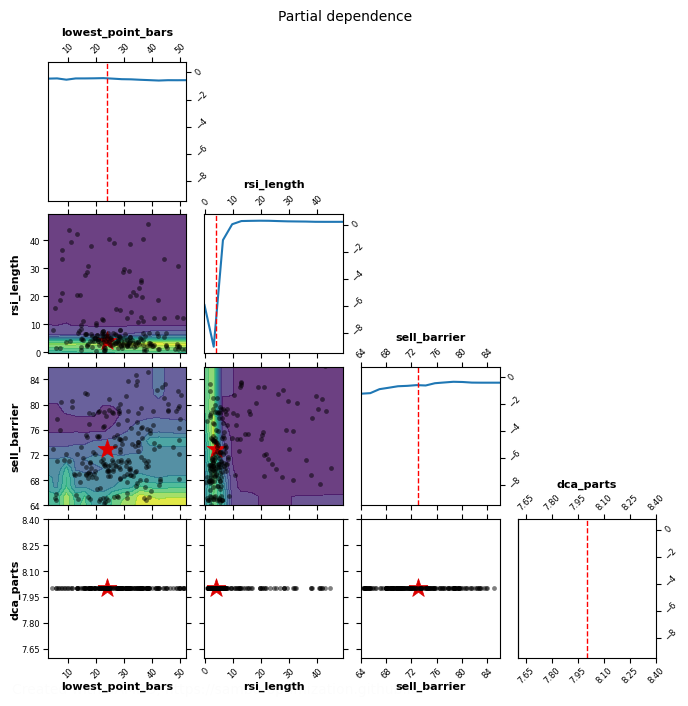

In [11]:
from sambo.plot import plot_objective
import numpy as np

# 更新参数名称以匹配文件中的参数，调整'sell_barrier'为'buy_barrier'
names = ['highest_point_bars', 'rsi_length', 'buy_barrier', 'dca_parts']
plot_dims = np.array(range(len(names)), dtype=np.int32)  # 使用int32类型
_ = plot_objective(optimize_result, names=names, estimator='et', plot_dims=plot_dims)

c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:266: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(*_get_lim('x', bounds, j))
c:\Users\x7498\anaconda3\envs\backtesting\lib\site-packages\sambo\plot.py:267: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*_get_lim('y', bounds, i))


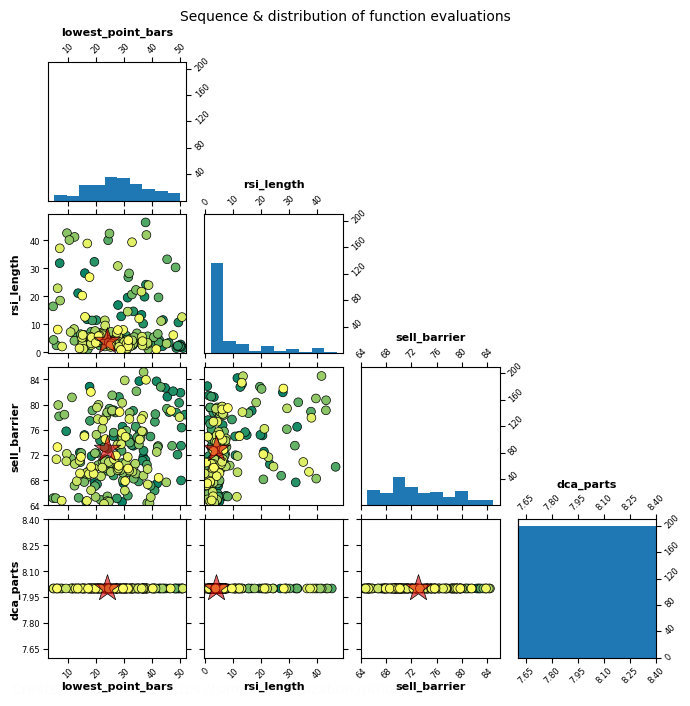

In [13]:
from sambo.plot import plot_evaluations

# 将plot_dims转换为int32类型
plot_dims = np.array(range(len(names)), dtype=np.int32)
_ = plot_evaluations(optimize_result, names=names, plot_dims=plot_dims)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).

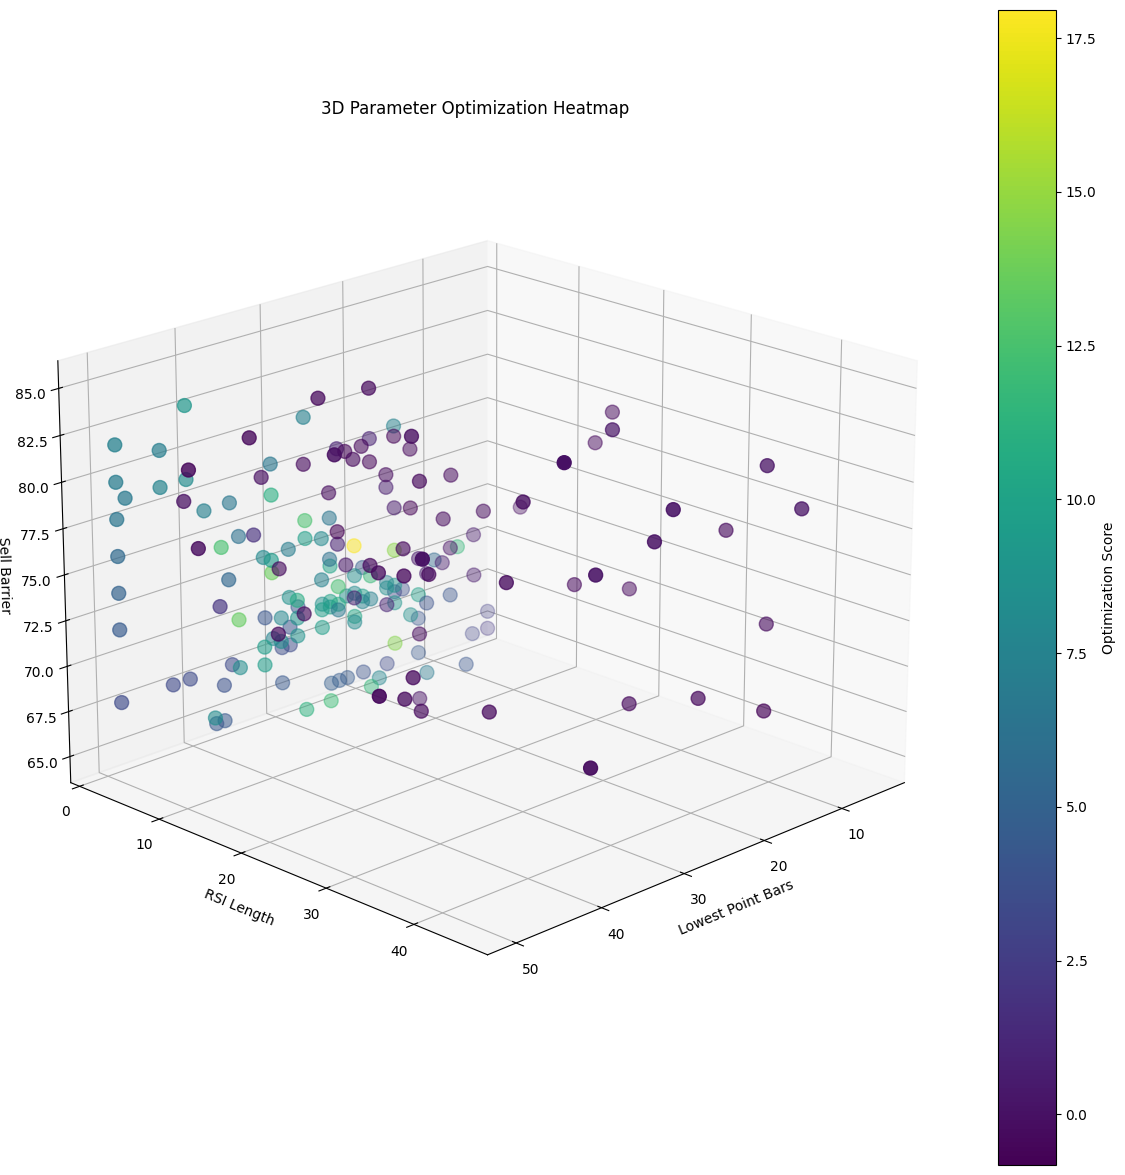


Top 5 Parameter Combinations:

Score: 17.9556
Lowest Point Bars: 24
RSI Length: 4
Sell Barrier: 73
DCA Parts: 8

Score: 14.6622
Lowest Point Bars: 19
RSI Length: 4
Sell Barrier: 72
DCA Parts: 8

Score: 14.5042
Lowest Point Bars: 20
RSI Length: 5
Sell Barrier: 67
DCA Parts: 8

Score: 13.6291
Lowest Point Bars: 34
RSI Length: 4
Sell Barrier: 73
DCA Parts: 8

Score: 13.4297
Lowest Point Bars: 38
RSI Length: 4
Sell Barrier: 71
DCA Parts: 8


In [14]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 创建三维散点图
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# 获取参数值
points = heatmap.index.to_frame()
scores = heatmap.values

# 创建散点图，用颜色表示得分（修改参数名称： 'sell_barrier' 改为 'buy_barrier'）
scatter = ax.scatter(points['highest_point_bars'], 
                     points['rsi_length'], 
                     points['buy_barrier'],
                     c=scores,
                     cmap='viridis',
                     s=100)  # 点的大小

# 设置标签（修改标签：‘Lowest Point Bars’ -> ‘Highest Point Bars’，‘Sell Barrier’ -> ‘Buy Barrier’）
ax.set_xlabel('Highest Point Bars')
ax.set_ylabel('RSI Length')
ax.set_zlabel('Buy Barrier')

# 添加颜色条
plt.colorbar(scatter, label='Optimization Score')

# 设置标题
plt.title('3D Parameter Optimization Heatmap')

# 调整视角以获得更好的视觉效果
ax.view_init(elev=20, azim=45)

# 添加网格线
ax.grid(True)

plt.show()

# 为了更好地理解最优参数区域，我们也可以打印出得分最高的前5个参数组合
print("\nTop 5 Parameter Combinations:")
top_5 = heatmap.sort_values(ascending=False).head(5)
for idx, score in top_5.items():
    print(f"\nScore: {score:.4f}")
    print(f"Highest Point Bars: {idx[0]}")
    print(f"RSI Length: {idx[1]}")
    print(f"Buy Barrier: {idx[2]}")
    print(f"DCA Parts: {idx[3]}")

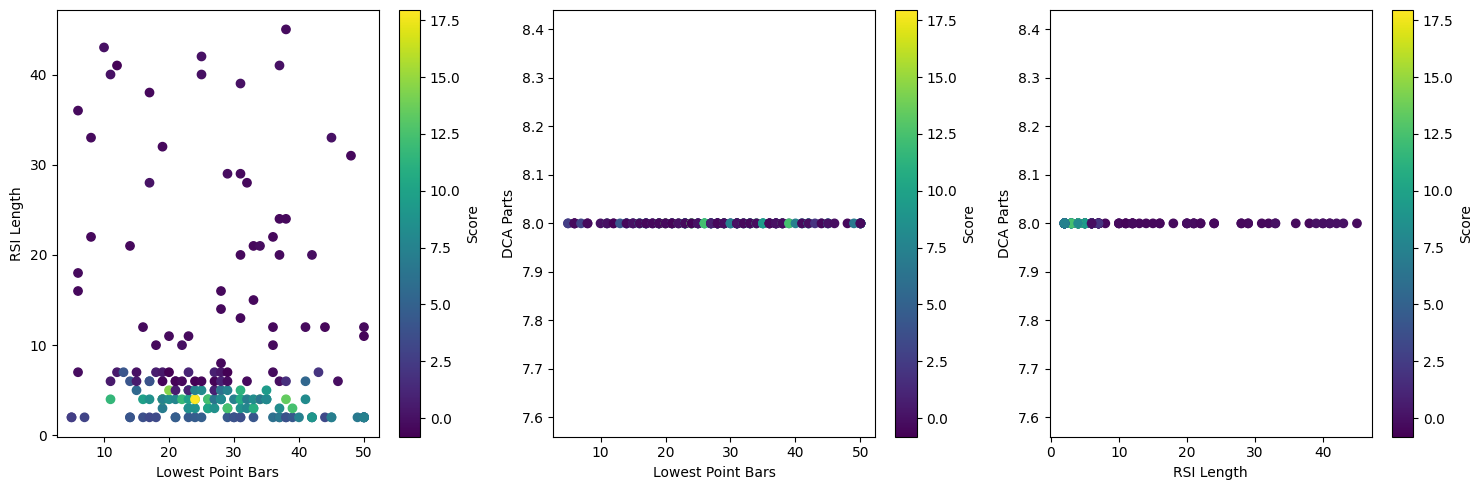

In [15]:
# 可选：添加二维投影图
fig = plt.figure(figsize=(15, 5))

# Highest Point Bars vs RSI Length
plt.subplot(131)
plt.scatter(points['highest_point_bars'], 
            points['rsi_length'], 
            c=scores, 
            cmap='viridis')
plt.xlabel('Highest Point Bars')
plt.ylabel('RSI Length')
plt.colorbar(label='Score')

# Highest Point Bars vs DCA Parts
plt.subplot(132)
plt.scatter(points['highest_point_bars'], 
            points['dca_parts'], 
            c=scores, 
            cmap='viridis')
plt.xlabel('Highest Point Bars')
plt.ylabel('DCA Parts')
plt.colorbar(label='Score')

# RSI Length vs DCA Parts
plt.subplot(133)
plt.scatter(points['rsi_length'], 
            points['dca_parts'], 
            c=scores, 
            cmap='viridis')
plt.xlabel('RSI Length')
plt.ylabel('DCA Parts')
plt.colorbar(label='Score')

plt.tight_layout()
plt.show()

In [11]:
from backtesting import Backtest

# 初始化回测实例
bt = Backtest(
    backtesting_df,
    ConnorsReversalShort,
    commission=.0004,
    margin=1/3,  # 8倍杠杆
    trade_on_close=True,  # 与TradingView的process_orders_on_close一致
    exclusive_orders=True,
    hedging=False  # 禁止对冲
)


# 使用最优参数运行回测
stats = bt.run(
    highest_point_bars=24,
    rsi_length=4,
    buy_barrier=73,
    dca_parts=8  # 修改为新的参数名
)
# Print backtest statistics
print("\n=== Backtest Results ===")
print(f"Total Return: {stats['Return [%]']:.2f}%")
print(f"Sharpe Ratio: {stats['Sharpe Ratio']:.2f}")
print(f"Max Drawdown: {stats['Max. Drawdown [%]']:.2f}%") 
print(f"Win Rate: {stats['Win Rate [%]']:.2f}%")
print(f"Total Trades: {stats['# Trades']}")



=== Backtest Results ===
Total Return: -5.49%
Sharpe Ratio: -0.71
Max Drawdown: -10.57%
Win Rate: 61.37%
Total Trades: 963


In [25]:
# 从 heatmap 中获取最优参数
best_idx = heatmap.sort_values(ascending=False).index[0]
best_params = {
    'highest_point_bars': best_idx[0],
    'rsi_length': best_idx[1],
    'buy_barrier': best_idx[2],
    'dca_parts': 8  # 修改后的参数名称
}

# 打印最优参数
print("\n=== Best Parameters ===")
print(f"Highest Point Bars: {best_params['highest_point_bars']}")
print(f"RSI Length: {best_params['rsi_length']}")
print(f"Buy Barrier: {best_params['buy_barrier']}")
print(f"DCA Parts: {best_params['dca_parts']}")

# 使用最优参数运行回测
stats = bt.run(
    highest_point_bars=best_params['highest_point_bars'],
    rsi_length=best_params['rsi_length'],
    buy_barrier=best_params['buy_barrier'],
    dca_parts=best_params['dca_parts']  # 使用修改后的参数名称
)

# 打印回测统计结果
print("\n=== Backtest Results ===")
print(f"Total Return: {stats['Return [%]']:.2f}%")
print(f"Sharpe Ratio: {stats['Sharpe Ratio']:.2f}")
print(f"Max Drawdown: {stats['Max. Drawdown [%]']:.2f}%")
print(f"Win Rate: {stats['Win Rate [%]']:.2f}%")
print(f"Total Trades: {stats['# Trades']}")

# 展示回测图形
try:
    bt.plot(resample=False)  # 禁用重采样以避免日期时间转换错误
except TypeError as e:
    print("Warning: Plot error, possibly due to data type conversion issues")
    print(f"Error message: {str(e)}")

NameError: name 'heatmap' is not defined